# Wagner-Whitin Problem for DEF Product Ordering

The goal of this exercise is to write code to solve the Wagner-Whitin problem using dynamic programming. CHEMOCO also orders another product, DEF, from a nearby supplier. For that purpose, it uses the Wagner-Whitin model.

## Problem Setup

Currently, the inventory on hand is 70. It is known that reordering costs 2900 euros, while the holding cost is 4 euros per unit per period. The demand for the entire year is estimated using historical averages over the last years. In Table 1, the parameters are summarized and the full data is given in the attached Excel file.

### Parameters

| Parameter              | Value                    | Meaning                        |
|------------------------|--------------------------|--------------------------------|
| K                      | 2900                     | Fixed cost                     |
| h                      | 4                        | Holding cost                   |
| T                      | 52                       | Horizon                        |
| [d1, ..., dT]          | [151, 136, 144, ..., 112, 49, 92] | Forecasted/planned demand     |
| I0                     | 70                       | Initial on-hand inventory      |

**Table 1**: Parameters for the Wagner-Whitin Model.

Can you find the optimal ordering policy for DEF? You may assume lead times are negligible, so ordering the goods in a particular week can immediately fulfill that week's demand. In the slides, we assumed that our `I0 = 0`, but we can modify the case of positive initial inventory (`I0 > 0`) by reducing the demand in `d1` by `I0` units. If `I0 > d1`, then the demand will be reduced in future periods until all `I0` units are accounted for. The first order is placed in the first period with non-zero revised demand, and the optimal cost for the horizon is the θ value for this period. **Note**: This approach assumes the holding cost for the initial inventory units is 0.

## Tasks

### 2a. Optimal Vector of Ordering Decisions

- Provide the optimal vector of ordering decisions, `Q*`, and plot them over the horizon.
- Also, provide the associated total cost.

The Wagner-Whitin problem is often solved on a rolling-horizon basis. In each period, we solve a sub-instance consisting of the current period (say, `t`) through the horizon’s end (say, `t + n − 1`). In the next period, we set `I0` equal to the current on-hand inventory and re-solve the problem, this time for a sub-instance consisting of periods `t + 1` through `t + n`, and so on.

It has been observed that the solution to the Wagner-Whitin problem is "nervous," meaning that when we shift the horizon by one period to create the next sub-instance, the entire solution, throughout the horizon, might change.

### 2b. Check for Nervousness

- Choose a horizon length `n`, for example, 4 weeks (a month) or 12 weeks (a quarter), and check whether your solution is nervous.


In [101]:
import pandas as pd

df = pd.read_excel("Homework_2 (Wagner-Within-instance).xlsx")
K = df["K"].values[0]
h = df["h"].values[0]
T = int(df["T"].values[0])
I_0 = df["I_0"].values[0]
d_t = {t: df[f"d{t}"].values[0] for t in range(1,T+1)}

In [102]:
# Change the demand in the first period to account for the initial inventory
def set_initial_inventory(I_0: int, d_t: dict[int, int], start: int = 1) -> dict[int, int]:
    if d_t[start] > I_0:
        d_t[start] -= I_0
        I_0 = 0
    elif I_0 > 0:
        i =start
        while I_0 > 0 and i <= max(d_t.keys()):
            decrease_with = min(I_0, d_t[i])
            I_0 -= decrease_with
            d_t[i] -= decrease_with
            i += 1
    return d_t

d_t = set_initial_inventory(I_0, d_t)

In [103]:
# Initialize theta_{T+1}
import numpy as np


def wagner_whitin(start: int = 1, end: int = T, K: float = K, h: float = h, d_t: dict[int, int] = d_t) -> tuple[dict[int, float], dict[int, int]]:
    theta = {end+1: 0}
    s_t = {}
    # Compute theta_t for t = T, T-1, ..., 1
    for t in range(end, start - 1, -1):
        step_two_minimisation = [K + h * sum([(i - t) * d_t[i] for i in range(t, s)]) + theta[s] for s in range(t+1, end+2)]
        theta[t] = min(step_two_minimisation)
        order_until_t = int(np.argmin(step_two_minimisation)) + t
        s_t[t] = order_until_t

    return theta, s_t

theta, s_t = wagner_whitin()
# Cost of optimal solution
int(theta[1])

60464

In [104]:
s_t

{52: 52,
 51: 52,
 50: 52,
 49: 52,
 48: 52,
 47: 49,
 46: 49,
 45: 49,
 44: 47,
 43: 47,
 42: 47,
 41: 42,
 40: 42,
 39: 41,
 38: 40,
 37: 40,
 36: 40,
 35: 40,
 34: 36,
 33: 35,
 32: 35,
 31: 34,
 30: 32,
 29: 32,
 28: 30,
 27: 30,
 26: 30,
 25: 30,
 24: 25,
 23: 25,
 22: 25,
 21: 25,
 20: 22,
 19: 22,
 18: 22,
 17: 20,
 16: 20,
 15: 20,
 14: 16,
 13: 16,
 12: 16,
 11: 16,
 10: 12,
 9: 12,
 8: 10,
 7: 10,
 6: 9,
 5: 8,
 4: 8,
 3: 6,
 2: 6,
 1: 3}

In [105]:
def get_order_vector(s_t: dict[int, int], end: int = T, start: int = 1, d_t: dict[int, int] = d_t) -> dict[int, int]:
    Q = {t: 0 for t in range(start, end+1)}
    next_s = min(s_t.keys())
    while next_s < end:
        Q[next_s] = sum([d_t[i] for i in range(next_s, s_t[next_s])])
        if s_t[next_s] >= end:
            Q[next_s] += d_t[end]
            break
        next_s = s_t[next_s]
    return Q
Q = get_order_vector(s_t)
assert sum(Q.values()) == sum(d_t.values()), "The sum of the orders (Q) and demand (d_t, adjusted for initial inventory) should be equal"
Q

{1: np.int64(217),
 2: 0,
 3: np.int64(230),
 4: 0,
 5: 0,
 6: np.int64(228),
 7: 0,
 8: 0,
 9: np.int64(349),
 10: 0,
 11: 0,
 12: np.int64(378),
 13: 0,
 14: 0,
 15: 0,
 16: np.int64(303),
 17: 0,
 18: 0,
 19: 0,
 20: np.int64(212),
 21: 0,
 22: np.int64(298),
 23: 0,
 24: 0,
 25: np.int64(497),
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: np.int64(186),
 31: 0,
 32: np.int64(279),
 33: 0,
 34: 0,
 35: np.int64(417),
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: np.int64(234),
 41: 0,
 42: np.int64(510),
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: np.int64(113),
 48: 0,
 49: np.int64(297),
 50: 0,
 51: 0,
 52: 0}

Text(0.5, 1.0, 'Inventory levels over time')

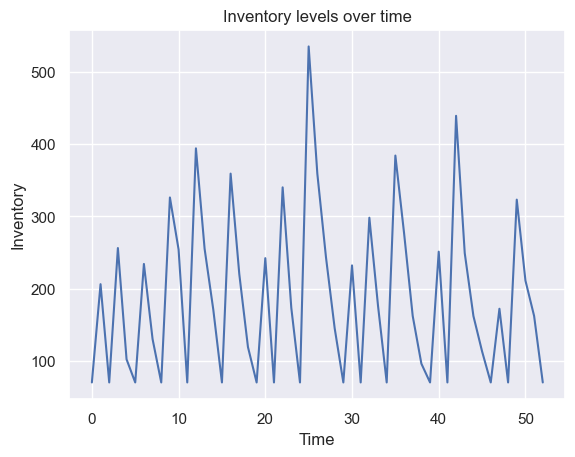

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

def get_inventory(I_0: int, Q: dict[int, int], d_t: dict[int, int], start: int = 1, end: int = T) -> dict[int, int]:
    inventory = {start-1: I_0}
    for t in range(start, end+1):
        inventory[t] = inventory[t-1] + Q[t] - d_t[t]
    return inventory

inventory = get_inventory(I_0, Q, d_t)
# Plot the inventory levels
sns.lineplot(x=range(T+1), y=list(inventory.values()))
plt.xlabel("Time")
plt.ylabel("Inventory")
plt.title("Inventory levels over time")

In [107]:
# Orders should be placed in the following periods with the following quantities
{t: int(Q[t]) for t in range(1, T+1) if Q[t] > 0}

{1: 217,
 3: 230,
 6: 228,
 9: 349,
 12: 378,
 16: 303,
 20: 212,
 22: 298,
 25: 497,
 30: 186,
 32: 279,
 35: 417,
 40: 234,
 42: 510,
 47: 113,
 49: 297}

In [ ]:
def run_test_on_nervousness(n: int, t: int = 1):
    # Run through the initial horizons end
    theta_one, s_t_one = wagner_whitin(start=t,end=t+n)
    Q_one = get_order_vector(s_t_one, end=t+n-1)

    inventory_one = get_inventory(I_0, Q_one, d_t, start=t, end=t+n-1)

    # Set the initial inventory for the next horizon
    new_d_t = {t: d_t[t] for t in range(t, t+n+2)}
    new_d_t = set_initial_inventory(start=t, I_0=inventory_one[t], d_t=new_d_t)

    # Run through the following horizon
    theta_two, s_t_two = wagner_whitin(start=t+1, end=t+n+1, d_t=new_d_t)
    Q_two = get_order_vector(s_t_two,start=t+1, end=t+n, d_t=new_d_t)

    inventory_two = get_inventory(inventory_one[t], Q_two, new_d_t, start=t+1, end=t+n) 

    # Plot two Q vectors next to each other in the same plot as barplots
    Q_one_vec = np.array([Q_one[t] for t in range(t, t+n-1)])
    Q_two_vec = np.array([Q_two[t] for t in range(t+1, t+n)])
    Q_one_vec = np.append(Q_one_vec, 0)
    Q_two_vec = np.insert(Q_two_vec, 0, 0)
    # Create a df where the first column is whether or not it is the first or second horizon and the second column is the order quantity
    df = pd.DataFrame({"Horizon": ["First" for _ in range(n)] + ["Second" for _ in range(n)], "Order Quantity": np.append(Q_one_vec, Q_two_vec), "Time": [i for i in range(t, t+n)] + [i for i in range(t+1, t+n+1)]})
    sns.catplot(data=df, x="Time",y="Order Quantity", hue="Horizon", kind="bar", height=5, aspect=2)
    # Add a text box under the legend on the right hand side with the theta values
    plt.text(1, 0.3, f"Optimal Costs:\nFirst horizon:      €{int(theta_one[t]):,}\nSecond horizon: €{int(theta_two[t+1]):,}", transform=plt.gcf().transFigure)

    # Plot the inventory levels
    # sns.lineplot(x=range(t, t+n+1), y=list(inventory_one.values()))
    # sns.lineplot(x=range(t+1, t+n+2), y=list(inventory_two.values()))
    # plt.xlabel("Time")
    # plt.ylabel("Inventory")
    # plt.title("Inventory levels over time")
    # plt.show()

{1: np.int64(0), 2: np.int64(0), 3: np.int64(0), 4: np.int64(0), 5: np.int64(0), 6: np.int64(0)}


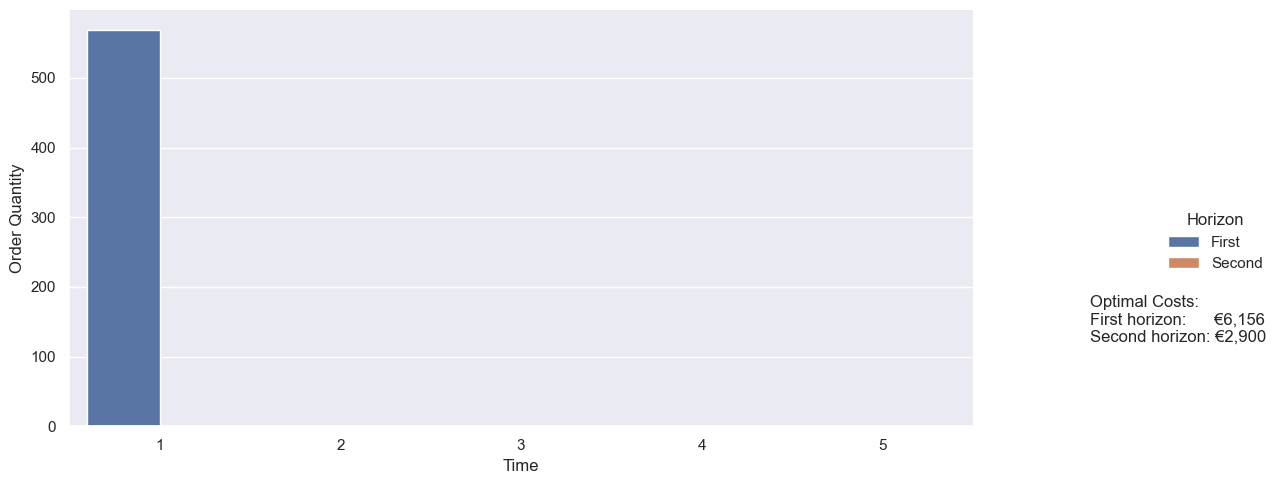

In [136]:
# Test the nervousness of the solution for 4 weeks
run_test_on_nervousness(4)

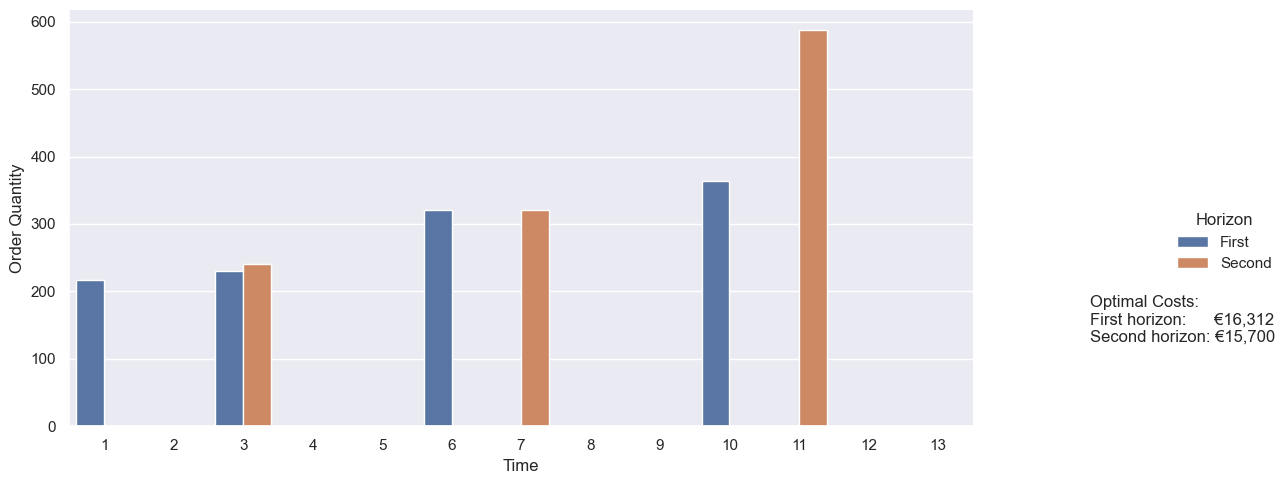

In [127]:
# Test the nervousness of the solution for 12 weeks or a quarter
run_test_on_nervousness(12)

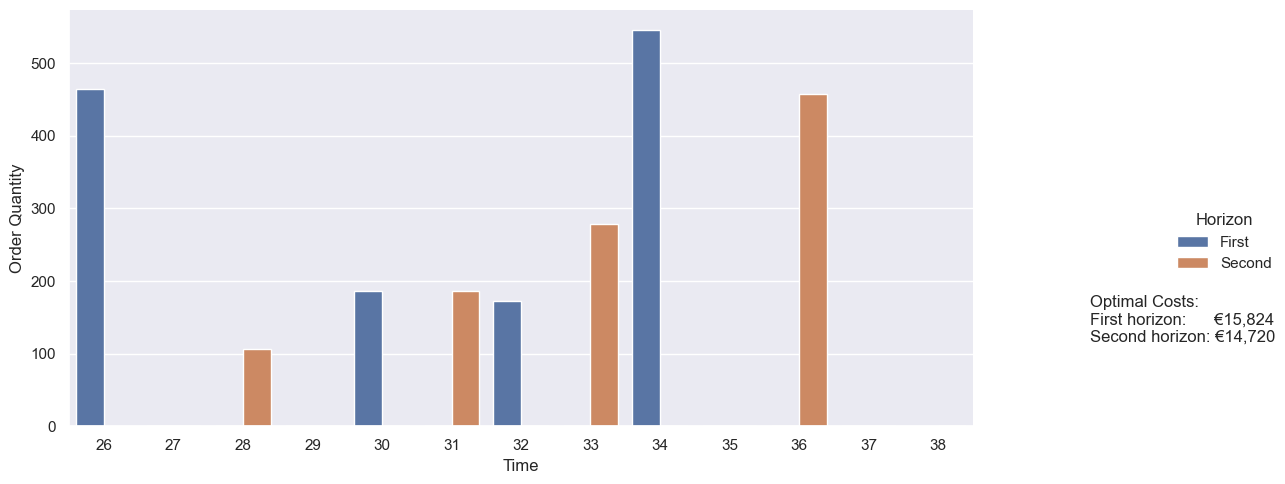

In [128]:
# Test the nervousness of the solution starting from week 26
run_test_on_nervousness(12, t=26)

### Nervousness
The different runs shows nervousness for longer time horizons. When running 4 weeks we observe that it has the same solution as the initial one. This is likely because the inventory levels for the following weeks are 0 in the initial solution. The reason we have non-zero costs for the second horizon in the 4 week run is because of how the algorithm of Wagner-Whitin is setup. The algorithm assumes that K will always be inccured, even if expected demand is 0 for the whole time horizon. This could easily be fixed by just returning $0$ for all $\theta_t$ and $s(t)=T+1$ for all t.

We can see that the solution is the most nervous on the run for 12 weeks starting in week 26. The second horizon solution is vastly different to the initial solution, showing that it is nervous. For example a big order is placed in week 34 in the initial solution, while in the second horizon it waits until week 36. We can observe that the optimal cost is lower for all in the second horizon, this is expected, and also likely why the solutions are nervous, since we have lower demand in the initial days in the second horizon, and we can see that we place big orders in all runs on the initial horizon.